In [1]:
#| default_exp widget


In [2]:
#| export
from __future__ import annotations


# Widget
> FashHTML widgets


# Prologue

In [3]:
#| export
from contextlib import contextmanager
from dataclasses import dataclass
from functools import partial
from types import MethodType
from typing import Any
from typing import Callable
from typing import Type

import traitlets as T
from fastcore.xml import to_xml
from fasthtml.core import FastHTML
from psygnal import Signal
from olio.common import val_at


In [4]:
#| export

from bridget.bridget import bridge_cfg
from bridget.common import Bridgeable
from bridget.common import Bridget
from bridget.common import DisplayId
from bridget.common import get_app
from bridget.common import RouteProvider
from bridget.helpers import id_gen
from bridget.routing import APIRouterD


In [5]:
#| export

from fasthtml.components import Div, Label, Input, Text, I


In [6]:
import fastcore.all as FC
import ipywidgets as W
from fastcore.test import *
from fasthtml.components import Button
from IPython.display import HTML
from IPython.display import Javascript
from IPython.display import Markdown
from rich.console import Console


In [7]:
from bridget.widget_helpers import cleanupwidgets
from bridget.routing import ar


----


In [8]:
#| exporti

DEBUG = True
new_id = id_gen()
_n = '\n'

In [9]:
cprint = (console := Console(width=120)).print

----

# Replacing ipywidgets with fasthtml

ipywidgets handles:
- **Layout**: ipywidgets uses python, JS -> replace with FastHTML, HTMX.
- **Comunication** kernel-frontend: ipywidgets uses Comm -> Bridget/HTTP-Ajax
- **Serialization**: ipywidgets uses Traitlets -> replace with pydantic, dataclasses, msgspec, pysignal.
- **Observer** pattern: ipywidgets uses Traitlets -> replace with custom or pysignal.


In [10]:
cleanupwidgets('brt')

app, brt, rt = get_app(True, auto_show=True, auto_mount=True, debug_req=True)


In [11]:
dv = Div(cls='bridget slider')
dv.set(cls=f"{dv.get('class')} value")
with bridge_cfg(auto_show=False):
    display(dv)


```html
<div class="bridget slider value"></div>

```

# Simple widget (Traitlets)


## Widget

In [12]:
class Widget(RouteProvider):
    bridget: Bridget = None  # type: ignore
    _updating, _mounted = False, False
    ar = APIRouterD()
    @contextmanager
    def _update_ctx(self):
        self._updating = True
        yield
        self._updating = False

    wrapper_class = 'bridget'
    def setup_wrapper_class(self):
        # return f"{type(self).wrapper_class}"
        return ' '.join(_.wrapper_class for _ in reversed(type(self).mro()) if hasattr(_, 'wrapper_class'))

    def __ft__(self):
        if bridge_cfg.auto_mount and not self._mounted: Bridget().mount(self, show=False)
        return Div(id=self.ar.name(), cls=self.setup_wrapper_class())
    def _ipython_display_(self):
        Bridget()(self)


In [13]:
app.routes.clear()

In [15]:
w = Widget()
with bridge_cfg(auto_show=False):
    display(w.__ft__())


```html
<div id="Widget_5129278560" class="bridget"></div>

```

## Value

In [16]:
class Value(T.HasTraits, Widget):
    value = T.Any()
    
    @T.observe('value')
    def on_value(self, _):
        if self.bridget and not self._updating:
            self.bridget.swap(f"#{self.ar.name()}", to_xml(self.__ft__()), swapStyle='innerHTML')

    @ar('/value', 'post')
    def changed(self, value:str):
        with self._update_ctx(): self.value = value
        return str(value)

    wrapper_class = 'value'
    def setup_value(self):
        return Input(name='value', value=self.value,
                hx_post=self.ar.to('changed'), hx_trigger='input changed', hx_swap='none')
    def setup_controls(self):
        # return Div(hx_post=f"{self.ar.to}/value", hx_target='innerHTML', hx_swap='textContent')(self.value)
        return (self.setup_value(), )
    
    def __ft__(self):
        return super().__ft__()(*self.setup_controls())


In [17]:
app.routes.clear()


In [18]:
v = Value(value='Hello, world!')
with bridge_cfg(auto_show=False):
    display(v.__ft__())
v


```html
<div id="Value_5129287104" class="bridget value">
  <input name="value" value="Hello, world!" hx-post="Value_5129287104/value" hx-trigger="input changed" hx-swap="none">
</div>

```

In [19]:
v.value

'Hello, world!aaaa'

In [20]:
v.value = 'bye!'

## IntSlider

In [21]:
@dataclass
class IntSlider(Value):
    value = T.CInt()
    min:int=0
    max:int=100
    step:int=1
    readout:bool=True
    readout_format:str='d'
    
    wrapper_class = 'slider'
    def setup_value(self):
        return Input(type='range', name='value', min=self.min, max=self.max, step=self.step, value=self.value,
                hx_post=f"/{self.ar.to()}/value", hx_trigger='input changed', 
                hx_target='next text', hx_swap='textContent')
    def setup_controls(self):
        return (Label(_for='value')('Scale'), _n,
                self.setup_value(),
                Text(id='spanscale', style='inline')(self.value), _n)



In [22]:
iv = IntSlider()
with bridge_cfg(auto_show=False):
    display(iv.__ft__())
iv


```html
<div id="IntSlider_1" class="bridget value slider">
<label for="value">Scale</label>
  <input type="range" name="value" max="100" step="1" hx-post="/IntSlider_1/value" hx-trigger="input changed" hx-swap="textContent" hx-target="next text">
<text id="spanscale" style="inline">0</text>
</div>

```

In [23]:
iv.value

74

In [24]:
iv.value = 77

In [25]:
iv2 = IntSlider(step=2)
iv2

In [26]:
iv3 = IntSlider()
iv4 = IntSlider()
# brt.mount(iv3, show=False)
# brt.mount(iv4, show=False)
T.link((iv3, 'value'), (iv4, 'value'))

box = Div(style='display: flex; gap: 1em;')(iv3, iv4)
box


div((IntSlider(min=0, max=100, step=1, readout=True, readout_format='d'), IntSlider(min=0, max=100, step=1, readout=True, readout_format='d')),{'style': 'display: flex; gap: 1em;'})

In [27]:
iv3.value = 22
test_eq(iv4.value, 22)


# Simple Widget (pysignal)


In [28]:
# import psygnal.utils
# psygnal.utils.decompile()

# psygnal.utils.recompile()

In [28]:
import dataclasses
from dataclasses import dataclass
from typing import ClassVar
import psygnal


## _WidgetRoutesProvider

In [29]:
class _WidgetRouteProvider(RouteProvider):
    bridget: Bridget = None  # type: ignore

    _mounted = False
    def __init_subclass__(cls): 
        if not 'events' in vars(cls): 
            cls.events = events = psygnal.SignalGroupDescriptor()
            events.__set_name__(cls, 'events') # call explicitly: outside class definition

    events: ClassVar[psygnal.SignalGroupDescriptor]
    def __post_init__(self):
        if dataclasses.is_dataclass(self):
            for fld in dataclasses.fields(self):
                name, mtdt = fld.name, fld.metadata.get('widget', {})
                if mtdt.get('skip', False): continue
                mth = mtdt.get('on', None) or getattr(self, f"on_{name}", None)
                if not mth: mth = partial(getattr(self, 'on_attr'), attr=name)
                if isinstance(mth, (MethodType, partial)):
                    self.events[fld.name].connect(mth)

    _updating_ = False
    @contextmanager
    def _updating(self): self._updating_ = True; yield; self._updating_ = False

    # @events('value')
    def on_attr(self, nw: Any, old: Any, *, attr:str):
        if hasattr(self, '__ft__') and self.bridget and not self._updating_:
            self.bridget.swap(f"#{self.ar.name()}", to_xml(self.__ft__()), swapStyle='innerHTML')

    def __ft__(self): ...
    

## Widget

In [32]:
_WCLSN = 'wrapper_class'

def _wrp_cls(cls: type) -> str:
    if issubclass(cls, Widget):
        return getattr(cls, _WCLSN) if _WCLSN in vars(cls) else cls.__name__.lower()
    return getattr(cls, _WCLSN) if hasattr(cls, _WCLSN) else ''

class Widget(_WidgetRouteProvider):
    dhdl: DisplayId | None = None
    contents: list[Bridgeable] = None  # type: ignore

    def update_(self, /, empty_value=None, **kwargs):
        "Update self in place with `kwargs` whose values aren't `empty_value`"
        for k, v in kwargs.items():
            if v is not empty_value: setattr(self, k, v)
        return self

    def setup_wrapper_class(self):
        return ' '.join(_wrp_cls(_) for _ in reversed(type(self).__mro__[:-1])).strip()

    def __call__(self, brble: Bridgeable, *, display_id=None, update=None, **kwargs):
        self.contents = [brble]
        update = True if self.dhdl else False
        self.dhdl = self.dhdl or DisplayId(new_id(self))
        Bridget()(self, display_id=self.dhdl, update=update, **kwargs)
    
    def __ft__(self):
        if bridge_cfg.auto_mount and not self._mounted: Bridget().mount(self, show=False)
        return Div(id=self.ar.name(), cls=self.setup_wrapper_class())(*(self.contents or ()))

    def _ipython_display_(self):
        if self.dhdl: self.dhdl.update()  # clear previous display
        self.dhdl = Bridget()(self, display_id=self.dhdl or new_id(self))


In [33]:
w = Widget()
with bridge_cfg(auto_show=False):
    display(w.__ft__())
w

```html
<div id="Widget_4905791808" class="widget"></div>

```

In [34]:
test_eq(w.contents, None)
w(Text('asdf'))

test_eq((_.list for _ in w.contents), [Text('asdf').list])  # type: ignore
test_eq(w.dhdl.contents(), f'<div id="{w.ar.name}" class="widget">\n<text>asdf</text></div>\n')  # type: ignore


In [35]:
w(Button('asdf'))

test_eq((_.list for _ in w.contents), (Button('asdf').list, ))  # type: ignore
test_eq(w.dhdl.contents(), f'<div id="{w.ar.name}" class="widget">\n<button>asdf</button></div>\n')  # type: ignore


## Output

In [36]:
# out = W.Output()
# out

In [37]:
# msg_id = None
# with out:
#     msg_id = out.msg_id
#     out.clear_output()
#     display(Text('Hello, world!'))
# msg_id


In [36]:
o = HTML('<div id="asdf">asdf</div>')
display(o)

In [37]:
from IPython.utils.capture import RichOutput, CapturedIO, capture_output

In [38]:
with capture_output() as io:
    display(Div(style='color: red;')(Text('Hi!')), HTML('<div id="asdf">asdf</div>'), 'Hi!', Markdown('Hi!'))
# io.outputs
# io.show()

In [39]:
io()

div((text(('Hi!',),{}),),{'style': 'color: red;'})

'Hi!'

Hi!

In [40]:
def _capture(*objs, **kwargs):
    from IPython.core.interactiveshell import InteractiveShell
    if not InteractiveShell.initialized():
        raise RuntimeError('IPython not initialized')
    outs = []
    format = InteractiveShell.instance().display_formatter.format
    for obj in objs:
        format_dict, md_dict = format(obj)
        if not format_dict:
            # nothing to display (e.g. _ipython_display_ took over)
            outs.append((None, None))
            continue
        outs.append((format_dict, md_dict))
    return outs

_capture(Div(style='color: red;')(Text('Hi!')), HTML('<div id="asdf">asdf</div>'), 'Hi!', Markdown('Hi!'))


div((text(('Hi!',),{}),),{'style': 'color: red;'})

[(None, None),
 ({'text/plain': '<IPython.core.display.HTML object>',
   'text/html': '<div id="asdf">asdf</div>'},
  {}),
 ({'text/plain': "'Hi!'"}, {}),
 ({'text/plain': '<IPython.core.display.Markdown object>',
   'text/markdown': 'Hi!'},
  {})]

In [41]:
def _capture_output(*objs, **kwargs):
    with capture_output() as io:
        display(*objs, **kwargs)
    return io

capt = _capture_output(Div(style='color: red;')(Text('Hi!')), HTML('<div id="asdf">asdf</div>'), 'Hi!', Markdown('Hi!'))
capt()
for c in capt.outputs:
    print(c._repr_mimebundle_())


div((text(('Hi!',),{}),),{'style': 'color: red;'})

'Hi!'

Hi!

({'text/plain': "div((text(('Hi!',),{}),),{'style': 'color: red;'})", 'text/html': '<div style="color: red;">\n<text>Hi!</text></div>\n'}, {})
({'text/plain': '<IPython.core.display.HTML object>', 'text/html': '<div id="asdf">asdf</div>'}, {})
({'text/plain': "'Hi!'"}, {})
({'text/plain': '<IPython.core.display.Markdown object>', 'text/markdown': 'Hi!'}, {})


In [42]:
class Output(Widget):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.contents = []
        Bridget().mount(self, show=False)
    # def __ft__(self):
    #     return super().__ft__()(id=self.idx)
    # def _ipython_display_(self):
    #     Bridget()(self, display_id=self.idx)
    def clear_output(self, wait=False):
        self.contents = []
        if not wait and self.dhdl: self.dhdl.update()
    # def capture(self, clear_output=False, *clear_args, **clear_kwargs):
    #     pass
    # @contextmanager
    # def managed_resource(*args, **kwds):
    #     # Code to acquire resource, e.g.:
    #     resource = acquire_resource(*args, **kwds)
    #     try:
    #         yield resource
    #     finally:
    #         # Code to release resource, e.g.:
    #         release_resource(resource)

    def __enter__(self):
        self._capt = capture_output()
        self._cio = self._capt.__enter__()
    def __exit__(self, etype, evalue, tb):
        bridge_cfg.current_did = None
        self._capt.__exit__(etype, evalue, tb)
        outputs, self._cio, self._capt = self._cio.outputs, None, None
        if not self.dhdl:
            dhdl = display(display_id=True)
            self.dhdl = DisplayId(dhdl.display_id)
        dhdl = self.dhdl.display_id
        for c in outputs:
            mime = {'data': c.data, 'metadata': c.metadata}
            self.contents.append(mime)
            display(mime['data'], metadata=mime['metadata'], raw=True, update=True, display_id=dhdl)
    
    # def _flush(self):
    #     pass
    def append_stdout(self, text):
        brt = self.bridget
        brt.swap(f"#{self.ar.name}", text+'<br>', swapStyle='beforeend')
        self.contents.append(text)
    def append_stderr(self, text):
        brt = self.bridget
        brt.swap(f"#{self.ar.name}", text+'<br>', swapStyle='beforeend')
        self.contents.append(text)
    def append_display_data(self, display_object):
        with capture_output() as io:
            display(display_object)
        mimebundle = io.outputs[0]._repr_mimebundle_()
        html = mimebundle[0]['text/html']
        brt = self.bridget
        brt.swap(f"#{self.ar.name}", html, swapStyle='beforeend')
        self.contents.append(display_object)


In [55]:
out = Output()
with bridge_cfg(auto_show=False):
    display(out.__ft__())
out


```html
<div id="Output_4906495552" class="widget output"></div>

```

In [56]:
out(Text('Hello, world!'))

In [59]:
out.append_stdout('Hello, universe!')


In [60]:
out.append_display_data(Div(style='color: red; padding: 0px;')(Text('Hello, red!')))
out.append_display_data(Button('adfrt'))

In [61]:
out.contents


[text(('Hello, world!',),{}),
 'Hello, universe!',
 'Hello, universe!',
 'Hello, universe!',
 div((text(('Hello, red!',),{}),),{'style': 'color: red; padding: 0px;'}),
 button(('adfrt',),{})]

In [62]:
out = Output()
with out:
    display('adfrt')
# out.contents


'adfrt'

In [63]:
out.append_display_data(Div(style='color: red; padding: 0px;')(Text('Hello, red!')))

In [54]:
out.contents

[{'data': {'text/plain': "'adfrt'"}, 'metadata': {}},
 div((text(('Hello, red!',),{}),),{'style': 'color: red; padding: 0px;'})]

In [69]:
import matplotlib.pyplot as plt


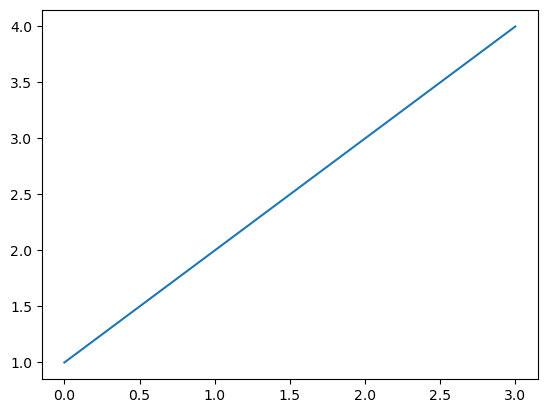

[{'data': {'text/plain': "button(('adfrt',),{})",
   'text/html': '<button>adfrt</button>'},
  'metadata': {}},
 {'data': {'text/plain': '<Figure size 640x480 with 1 Axes>',
   'image/png': 'iVBORw0KGgoAAAANSUhEUgAAAiMAAAGdCAYAAADAAnMpAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAABABklEQVR4nO3deVxVdeL/8ddlRzZFBUFwV1xQBG2h0cosTctysk37Ns3Wb2xwSbJF26ZpimaycsGsJmtqDDVDzUYzbUFbtFIuuG+5gAgiLoAgF7j3/P7om9+xUAGBc7n3/Xw87h/38DndN6dP3Hfnc+65FsMwDERERERM4mF2ABEREXFvKiMiIiJiKpURERERMZXKiIiIiJhKZURERERMpTIiIiIiplIZEREREVOpjIiIiIipvMwOUBsOh4MjR44QFBSExWIxO46IiIjUgmEYlJaWEhkZiYfH+c9/NIsycuTIEaKjo82OISIiIvWQm5tLVFTUeX/eLMpIUFAQ8OMvExwcbHIaERERqY2SkhKio6PPvo+fT7MoIz8tzQQHB6uMiIiINDMXu8RCF7CKiIiIqVRGRERExFQqIyIiImIqlRERERExlcqIiIiImEplREREREylMiIiIiKmUhkRERERU6mMiIiIiKkuqYykpKRgsVh48MEHLzhu3bp1DBgwAD8/P7p06cJrr712KS8rIiIiLqTeZeT777/njTfeoF+/fhccd+DAAUaOHMngwYOxWq1Mnz6dSZMmkZ6eXt+XFhERERdSrzJy+vRp7rnnHv75z3/SqlWrC4597bXX6NChAzNnz

In [70]:
with out:
    fig = plt.figure(figsize=(4, 2.67))
    plt.plot([1,2,3,4])
    # plt.show()
out.contents

In [ ]:
# with out:
#     plt.plot([1,2,3,4])
#     plt.show()

----

In [ ]:
out = Output(layout={'border': '1px solid black'})
out


In [ ]:
with out:
    for i in range(10):
        print(i, 'Hello world!')

In [ ]:
from IPython.display import YouTubeVideo
with out:
    display(YouTubeVideo('eWzY2nGfkXk'))

In [ ]:
with out:
    display(widgets.IntSlider())

In [ ]:
out = widgets.Output(layout={'border': '1px solid black'})
out.append_stdout('Output appended with append_stdout')
out.append_display_data(YouTubeVideo('eWzY2nGfkXk'))
out

In [ ]:
@out.capture()
def function_with_captured_output():
    print('This goes into the output widget')
    raise Exception('As does this')
    
function_with_captured_output()

In [ ]:
a = widgets.IntSlider(description='a')
b = widgets.IntSlider(description='b')
c = widgets.IntSlider(description='c')
def f(a, b, c):
    print('{}*{}*{}={}'.format(a, b, c, a*b*c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

widgets.HBox([widgets.VBox([a, b, c]), out])

## Control

In [ ]:
class Control(Widget):
    pass

test_eq(_wrp_cls(Control), 'control')


## Value

In [ ]:
@dataclass
class Value(Widget):
    value: Any = None

    @ar('/value', methods=['POST'])
    def changed(self, value:str):
        with self._updating(): self.value = value
        return self.value

    def setup_value(self):
        return Input(name='value', value=self.value,
                hx_post=f"{self.ar.to}/value", hx_trigger='input changed', hx_swap='none')
    def setup_controls(self):
        return (self.setup_value(), )
    
    def __ft__(self):
        return super().__ft__()(*self.setup_controls())


In [ ]:
cprint(dataclasses.fields(Value))

(
    Field(name='value',type='Any',default=None,default_factory=<dataclasses._MISSING_TYPE object at 
0x1061a2930>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
)

In [ ]:
v = Value('Hello, world!')
with bridge_cfg(auto_show=False):
    display(v.__ft__())
v


```html
<div id="Value_1" class="widget value">
  <input name="value" value="Hello, world!" hx-post="/Value_1/value" hx-trigger="input changed" hx-swap="none">
</div>

```

In [ ]:
v.value

'Hello, world!as'

In [ ]:
v.value = 'bye!'

## IntText


In [ ]:
@dataclass
class IntText(Value):
    value: int = 0
    @ar('/value', methods=['POST'])
    def changed(self, value:int):
        with self._updating(): self.value = value
        return self.value
    def setup_value(self):
        return Input(name='value', value=self.value, type='number', 
                hx_post=f"{self.ar.to}/value", hx_trigger='input changed throttle:100ms', hx_swap='none')


In [ ]:
v = IntText(5)
with bridge_cfg(auto_show=False):
    display(v.__ft__())
v


```html
<div id="IntText_1" class="widget value inttext">
  <input name="value" value="5" type="number" hx-post="/IntText_1/value" hx-trigger="input changed throttle:100ms" hx-swap="none">
</div>

```

In [ ]:
v.value

5

In [ ]:
v.value = 17

## BoundedInt

In [ ]:
@dataclass
class BoundedInt(IntText):
    min: int = 0
    max: int = 100
    step: int = 1

    def on_attr(self, nw: Any, old: Any, *, attr:str):
        if attr != 'value': 
            if (val := self.value) < self.min:
                with self.events.value.blocked():
                    self.value = self.min
            elif val > self.max:
                with self.events.value.blocked():
                    self.value = self.max
        super().on_attr(nw, old, attr=attr)

    def setup_value(self):
        return super().setup_value()(min=self.min, max=self.max, step=self.step)


In [ ]:
v = BoundedInt(10, 5, 15)
with bridge_cfg(auto_show=False):
    display(v.__ft__())
v


```html
<div id="BoundedInt_1" class="widget value inttext boundedint">
  <input name="value" value="10" type="number" hx-post="/BoundedInt_1/value" hx-trigger="input changed throttle:100ms" hx-swap="none" min="5" max="15" step="1">
</div>

```

In [ ]:
v.value

10

In [ ]:
v.max = 10

## IntSlider

In [ ]:
@dataclass
class IntSlider(BoundedInt):
    readout: bool = True
    readout_format: str = 'd'
    
    # @ar('/value', methods=['POST'])
    # def changed(self, value:int):
    #     return super().changed(value)

    wrapper_class = 'slider'
    def setup_value(self):
        return super().setup_value()(type='range', hx_target='next text', hx_swap='textContent')
        # return Input(type='range', name='value', min=self.min, max=self.max, step=self.step, value=self.value,
        #         hx_post=f"{self.ar.to}/value", hx_trigger='input changed throttle:100ms', 
        #         hx_target='next text', hx_swap='textContent')
    def setup_controls(self):
        return (Label(_for='value')('Scale'), _n,
                self.setup_value(),
                Text(id='spanscale', style='inline')(self.value), _n)



In [ ]:
cprint(dataclasses.fields(IntSlider))

(
    Field(name='value',type='int',default=0,default_factory=<dataclasses._MISSING_TYPE object at 
0x1061a2930>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
    Field(name='min',type='int',default=0,default_factory=<dataclasses._MISSING_TYPE object at 
0x1061a2930>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
    Field(name='max',type='int',default=100,default_factory=<dataclasses._MISSING_TYPE object at 
0x1061a2930>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
    Field(name='step',type='int',default=1,default_factory=<dataclasses._MISSING_TYPE object at 
0x1061a2930>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
    Field(name='readout',type='bool',default=True,default_factory=<dataclasses._MISSING_TYPE object at 
0x1061a2930>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
    Field(name='readout_format',type='str',default='d',default_factory=<dataclasses._MISSING_TYPE object at 
0x1061a2930>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD)
)

In [ ]:
iv = IntSlider()
with bridge_cfg(auto_show=False):
    display(iv.__ft__())
iv


```html
<div id="IntSlider_5" class="widget value inttext boundedint slider">
<label for="value">Scale</label>
  <input name="value" type="range" hx-post="/IntSlider_5/value" hx-trigger="input changed throttle:100ms" hx-swap="textContent" max="100" step="1" hx-target="next text">
<text id="spanscale" style="inline">0</text>
</div>

```

In [ ]:
iv.value

0

In [ ]:
iv.value = 89

In [ ]:
iv.min = 20
test_eq(iv.value, 89)

In [ ]:
iv.max = 80
test_eq(iv.value, 80)

In [ ]:
iv2 = IntSlider(step=2)
iv2

## IntProgress

In [ ]:
w = W.IntProgress()
w

IntProgress(value=0)

In [ ]:
w.value = 50

In [ ]:
from bridget.bridget import Style
from fastcore.xml import NotStr

_css_ = """
.inline-hbox {
    box-sizing: border-box;
    display: flex;
    flex-direction: row;
    align-items: baseline;
}
.hprogress {
    height: 28px;
    height: var(--jp-widgets-inline-height);
    line-height: 28px;
    line-height: var(--jp-widgets-inline-height);
    width: 300px;
    width: var(--jp-widgets-inline-width);
    align-items: center;
}

.hprogress .progress {
    flex-grow: 1;
    margin-top: 4px;
    margin-top: var(--jp-widgets-input-padding);
    margin-bottom: 4px;
    margin-bottom: var(--jp-widgets-input-padding);
    align-self: stretch;
    height: auto;
    height: initial;
}

.progress {
    background-color: #eeeeee;
    background-color: var(--jp-layout-color2);
    border: none;
    box-shadow: none;
}

.progress-bar {
    background-color: #2196f3;
    background-color: var(--jp-brand-color1);
    position: absolute; 
    bottom: 0px; 
    left: 0px; 
    width: 0%; 
    height: 100%;
}
"""
# with bridge_cfg(auto_show=False): 
#     display(Style(NotStr(_css_)))
Div('IntProgress style', Style(NotStr(_css_)))


div(('IntProgress style', style(('\n.inline-hbox {\n    box-sizing: border-box;\n    display: flex;\n    flex-direction: row;\n    align-items: baseline;\n}\n.hprogress {\n    height: 28px;\n    height: var(--jp-widgets-inline-height);\n    line-height: 28px;\n    line-height: var(--jp-widgets-inline-height);\n    width: 300px;\n    width: var(--jp-widgets-inline-width);\n    align-items: center;\n}\n\n.hprogress .progress {\n    flex-grow: 1;\n    margin-top: 4px;\n    margin-top: var(--jp-widgets-input-padding);\n    margin-bottom: 4px;\n    margin-bottom: var(--jp-widgets-input-padding);\n    align-self: stretch;\n    height: auto;\n    height: initial;\n}\n\n.progress {\n    background-color: #eeeeee;\n    background-color: var(--jp-layout-color2);\n    border: none;\n    box-shadow: none;\n}\n\n.progress-bar {\n    background-color: #2196f3;\n    background-color: var(--jp-brand-color1);\n    position: absolute; \n    bottom: 0px; \n    left: 0px; \n    width: 0%; \n    height: 100%;\n}\n',),{})),{})

In [ ]:
class IntProgress(BoundedInt):
    def setup_value(self):
        return Div(cls='hprogress inline-hbox')(
            Div(cls='progress', style='position: relative;')(
                Div(cls='progress-bar', style=f"width: {(self.value-self.min)/(self.max-self.min)*100}%;")
            )
        )


In [ ]:
ip = IntProgress(25)
with bridge_cfg(auto_show=False):
    display(ip.__ft__())
ip


```html
<div id="IntProgress_1" class="widget value inttext boundedint intprogress">
  <div class="hprogress inline-hbox">
    <div class="progress" style="position: relative;">
      <div class="progress-bar" style="width: 25.0%;"></div>
    </div>
  </div>
</div>

```

In [ ]:
ip.value = 33

## Bool

```HTML
<div class="lm-Widget p-Widget jupyter-widgets widget-valid widget-inline-hbox mod-invalid"><label class="widget-label" title="null" style="display: none;"></label><i class="fa fa-fw fa-times"></i><span class="widget-valid-readout widget-readout">Invalid</span></div>
```

In [ ]:
w = W.Valid()
w


Valid(value=False)

In [ ]:
w = W.Checkbox()
w


Checkbox(value=False)

In [ ]:
w = W.ToggleButton()
w


ToggleButton(value=False)

In [ ]:
class Valid(Value):
    value: bool = False
    readout: str = 'Invalid'
    def setup_value(self):
        return Div(cls='valid inline-hbox mod-invalid')(
            I(cls='fa fa-fw fa-times'),
            Text(cls='readout')(self.readout)
        )


In [ ]:
class Checkbox(Valid):
    pass


In [ ]:
class ToggleButton(Valid):
    pass


## Link
> implement a link functionality similar to `Traitlets`' `link` and `directional_link` using `Psygnal`'s signal system. 

The key differences are:
- Traitlets uses traits/attributes while Psygnal uses signals
- Psygnal has built-in type checking and argument validation

We'll need to handle cleanup/disconnection properly

In [ ]:
class Link:
    "Links two attributes of objects with two signals to keep them in sync bidirectionally."
    
    def __init__(
        self,
        source: tuple[Any, str] | tuple[Any, str, str] | psygnal.SignalInstance,
        target: tuple[Any, str] | tuple[Any, str, str] | psygnal.SignalInstance, 
        transform: tuple[Callable, Callable]|None = None
    ):
        self._setup(source, target, transform)
        self.updating = False
        self._link()
    
    def _setup(self, source, target, transform):
        if isinstance(source, psygnal.SignalInstance):
            self._src, self._src_name = source.instance.all.instance, source.name
            self._src_signal = source
        else:
            self._src, self._src_name = source[:2]
            self._src_signal = getattr(self._src, source[2] if len(source) == 3 else f"{self._src_name}_changed")
        if isinstance(target, psygnal.SignalInstance):
            self._tgt, self._tgt_name = target.instance.all.instance, target.name
            self._tgt_signal = target
        else:
            self._tgt, self._tgt_name = target[:2]
            self._tgt_signal = getattr(self._tgt, target[2] if len(target) == 3 else f"{self._tgt_name}_changed")
        self._transform = transform or (lambda x: x, lambda x: x)

    @contextmanager
    def _busy_updating(self):
        self.updating = True
        try: yield
        finally: self.updating = False
            
    def _link(self):
        """Establish bidirectional connection between signals."""
        self._src_signal.connect(self._source_to_target)
        self._tgt_signal.connect(self._target_to_source)
                    
    def _source_to_target(self, x):
        if self.updating: return
        with self._busy_updating():
            setattr(self._tgt, self._tgt_name, self._transform[0](x))
    
    def _target_to_source(self, x):
        if self.updating: return
        with self._busy_updating():
            setattr(self._src, self._src_name, self._transform[1](x))
    
    def unlink(self):
        self._src_signal.disconnect()
        self._tgt_signal.disconnect()


class DirectionalLink:
    """Links source signal to target signal unidirectionally."""
    
    def __init__(
        self,
        source: tuple[Any, str] | tuple[Any, str, str] | psygnal.SignalInstance,
        target: tuple[Any, str], 
        transform: Callable|None = None 
    ):
        self._setup(source, target, transform)
        self.updating = False
        self._link()

    def _setup(self, source, target, transform):
        if isinstance(source, psygnal.SignalInstance):
            self._src, self._src_name = source.instance, source.name
            self._src_signal = source
        else:
            self._src, self._src_name = source[:2]
            self._src_signal = getattr(self._src, source[2] if len(source) == 3 else f"{self._src_name}_changed")
        self._tgt, self._tgt_name = target[:2]
        self._transform = transform or (lambda x: x)

    @contextmanager
    def _busy_updating(self):
        self.updating = True
        try: yield
        finally: self.updating = False
            
    def _link(self):
        """Establish unidirectional connection from source to target."""
        self._src_signal.connect(self._source_to_target)
        
    def _source_to_target(self, x):
        if self.updating: return
        with self._busy_updating():
            setattr(self._tgt, self._tgt_name, self._transform(x))
                    
    def unlink(self):
        self._src_signal.disconnect()



In [ ]:
class ValueHolder:
    value_changed = Signal(int)  # Signal that emits integers
    
    def __init__(self, value: int = 0):
        self._value = value
        
    @property 
    def value(self) -> int:
        return self._value
        
    @value.setter
    def value(self, val: int):
        if val != self._value:
            self._value = val
            self.value_changed.emit(val)

# Create instances
source = ValueHolder(1)
target = ValueHolder(42)

# Create bidirectional link
link = Link((source, "value"), (target, "value"))

source.value = 5
test_eq(target.value, 5)
target.value = 10
test_eq(source.value, 10)


In [ ]:
def celsius_to_fahrenheit(c: float) -> float:
    return (c * 9/5) + 32

temp_c = ValueHolder(0)
temp_f = ValueHolder(32)

# Link Celsius to Fahrenheit with transform
dir_link = DirectionalLink(
    (temp_c, "value"),
    (temp_f, "value"), 
    transform=celsius_to_fahrenheit
)

temp_c.value = 100
test_eq(temp_f.value, 212)
temp_f.value = 50
test_eq(temp_c.value, 100)


In [ ]:
iv3 = IntSlider(7)
iv4 = IntSlider(17)

box = Div(style='display: flex; gap: 1em;')(iv3, iv4)
box


div((IntSlider(value=7, min=0, max=100, step=1, readout=True, readout_format='d'), IntSlider(value=17, min=0, max=100, step=1, readout=True, readout_format='d')),{'style': 'display: flex; gap: 1em;'})

In [ ]:
lnk = Link(iv3.events.value, iv4.events.value);


In [ ]:
iv3.value = 22
test_eq(iv4.value, 22)


## Box

In [ ]:
primes = list(map(int, """
2	3	5	7	11	13	17	19	23	29	31	37	41	43	47	53	59	61	67	71
73	79	83	89	97	101	103	107	109	113	127	131	137	139	149	151	157	163	167	173
179	181	191	193	197	199	211	223	227	229	233	239	241	251	257	263	269	271	277	281
283	293	307	311	313	317	331	337	347	349	353	359	367	373	379	383	389	397	401	409
419	421	431	433	439	443	449	457	461	463	467	479	487	491	499	503	509	521	523	541
547	557	563	569	571	577	587	593	599	601	607	613	617	619	631	641	643	647	653	659
661	673	677	683	691	701	709	719	727	733	739	743	751	757	761	769	773	787	797	809
811	821	823	827	829	839	853	857	859	863	877	881	883	887	907	911	919	929	937	941
947	953	967	971	977	983	991	997""".split()))
len(primes)

168

In [ ]:
@dataclass
class Box(Widget):
    children: tuple[Widget, ...] = ()

    def __ft__(self):
        return super().__ft__()(style='display: flex; gap: 1em;')(*(c.__ft__() for c in self.children))

bx = Box((IntSlider(23), IntSlider(59)))
with bridge_cfg(auto_show=False):
    display(bx.__ft__())
bx


```html
<div id="Box_1" class="widget box" style="display: flex; gap: 1em;">
  <div id="IntSlider_9" class="widget value inttext boundedint slider">
<label for="value">Scale</label>
    <input name="value" value="23" type="range" hx-post="/IntSlider_9/value" hx-trigger="input changed throttle:100ms" hx-swap="textContent" max="100" step="1" hx-target="next text">
<text id="spanscale" style="inline">23</text>
  </div>
  <div id="IntSlider_10" class="widget value inttext boundedint slider">
<label for="value">Scale</label>
    <input name="value" value="59" type="range" hx-post="/IntSlider_10/value" hx-trigger="input changed throttle:100ms" hx-swap="textContent" max="100" step="1" hx-target="next text">
<text id="spanscale" style="inline">59</text>
  </div>
</div>

```

In [ ]:
bx.children = (IntSlider(19), IntSlider(31), IntSlider(71))

## interactive_output


In [ ]:
def interactive_output(f, controls):
    """Connect widget controls to a function.

    This function does not generate a user interface for the widgets (unlike `interact`).
    This enables customisation of the widget user interface layout.
    The user interface layout must be defined and displayed manually.
    """

    out = Output()
    def observer(change):
        kwargs = {k:v.value for k,v in controls.items()}
        show_inline_matplotlib_plots()
        with out:
            clear_output(wait=True)
            f(**kwargs)
            show_inline_matplotlib_plots()
    for k,w in controls.items():
        w.observe(observer, 'value')
    show_inline_matplotlib_plots()
    observer(None)
    return out


In [ ]:
a = W.IntSlider()
b = W.IntSlider()
c = W.IntSlider()
ui = W.HBox([a, b, c])
def f(a, b, c):
    print((a, b, c))

out = W.interactive_output(f, {'a': a, 'b': b, 'c': c})

display(ui, out)

Output()

## interactive

In [ ]:
from IPython.display import display
def f(a, b):
    display(a + b)
    return a+b

In [ ]:
w = interactive(f, a=10, b=20)

In [ ]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.out#children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='m', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

## interact

In [ ]:
def f(x):
    return x

In [ ]:
interact(f, x=10);

In [ ]:
interact(f, x=True);

In [ ]:
interact(f, x='Hi there!');

In [ ]:
@interact(x=True, y=1.0)
def g(x, y):
    return (x, y)


In [ ]:
IntSlider(min=-10, max=30, step=1, value=10)

In [ ]:
interact(f, x=widgets.IntSlider(min=-10, max=30, step=1, value=10));


## interact_manual

# Colophon
----


In [ ]:
import fastcore.all as FC
import nbdev
from nbdev.clean import nbdev_clean


In [ ]:
if FC.IN_NOTEBOOK:
    nb_path = '50_wridget.ipynb'
    # nbdev_clean(nb_path)
    nbdev.nbdev_export(nb_path)
